In [1]:
%load_ext autoreload
#import race
#import math
#import random

#import gym
import numpy as np

#import torch
#import torch.nn as nn
#import torch.optim as optim
#import torch.nn.functional as F
#from torch.distributions import Normal

#from IPython.display import clear_output
import matplotlib.pyplot as plt
import optuna
#import importlib
import CurvyRaceEnv
#importlib.reload(CurvyRaceEnv)
%matplotlib inline
%reload_ext autoreload

In [2]:
from stable_baselines3.common.env_checker import check_env
#import CurvyRaceEnv
test = CurvyRaceEnv.CurvyRaceEnv()
check_env(test)

C:\Studium\MasterStudium\DRL\Studienarbeiten\Studienarbeit2\DRL_Studienarbeit2_env\Lib\site-packages\stable_baselines3\common\env_checker.py:441: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(
C:\Studium\MasterStudium\DRL\Studienarbeiten\Studienarbeit2\DRL_Studienarbeit2_env\Lib\site-packages\stable_baselines3\common\env_checker.py:452: UserWarning: Your action space has dtype float64, we recommend using np.float32 to avoid cast errors.
  warnings.warn(


In [3]:
from gymnasium.envs.registration import register

register(
     id="CurvyRaceEnv-v0",
     entry_point="CurvyRaceEnv:CurvyRaceEnv",
     max_episode_steps=100,
)

In [4]:
from typing import Any
from typing import Dict

import gymnasium
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
from stable_baselines3 import A2C
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import StopTrainingOnNoModelImprovement
from stable_baselines3.common.callbacks import EvalCallback, BaseCallback

import torch
import torch.nn as nn
import time
N_TRIALS = 10000
N_STARTUP_TRIALS = 5
N_EVALUATIONS = 2
N_TIMESTEPS = 20000
EVAL_FREQ = int(N_TIMESTEPS / N_EVALUATIONS)
N_EVAL_EPISODES = 3

ENV_ID = "CurvyRaceEnv-v0"

DEFAULT_HYPERPARAMS = {
    "policy": "MlpPolicy",
    "env": ENV_ID,
}

In [5]:
def evaluate_model(model, env, num_episodes=100):  
    
    total_reward = 0.0
    for _ in range(num_episodes):
        obs, info = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs)
            obs, reward, done,info, _ = env.step(action)
            total_reward += reward
    mean_reward = total_reward / num_episodes
    return mean_reward

In [6]:
from stable_baselines3 import A2C, PPO, TD3, DDPG, SAC
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

def objective(trial: optuna.Trial) -> float:   
    hyperparams = {
        'learning_starts': trial.suggest_int('learning_starts', 50,400),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
        'gamma': trial.suggest_float('gamma', 0.9, 0.999),
        'tau': trial.suggest_float('tau', 1e-3, 1e-1, log=True)   
    }
    # Define the environment
    env = gymnasium.make('CurvyRaceEnv-v0')  
    


    
    
    

    # Create and train the DDPG model
    model = SAC('MlpPolicy', env, learning_starts=hyperparams['learning_starts'] ,learning_rate=hyperparams['learning_rate'],
                 gamma=hyperparams['gamma'], tau=hyperparams['tau'],
                 action_noise=NormalActionNoise(mean=np.zeros(env.action_space.shape), sigma=0.1 * np.ones(env.action_space.shape)))
    
    # Train the model
    model.learn(total_timesteps=50000)  # Adjust the total_timesteps as needed

    # Evaluate the model
    mean_reward = evaluate_model(model, env)

    return mean_reward

In [7]:
#study = optuna.create_study(study_name="SAC", storage="sqlite:///DRL2.db", load_if_exists=True, direction="maximize")
#study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

In [8]:
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold

eval_env = gymnasium.make("CurvyRaceEnv-v0")
eval_callback = EvalCallback(eval_env, best_model_save_path='model/best_model',
                            log_path='logs/best_model_log', eval_freq=1000,
                            deterministic=True, render=False,
                            callback_on_new_best=StopTrainingOnRewardThreshold(reward_threshold=3500, verbose=1))

In [ ]:
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3 import DDPG, TD3, SAC, A2C,PPO
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise


env = gymnasium.make("CurvyRaceEnv-v0")
#env = Monitor(env, "logs/ddpg")
#model_ddpg = DDPG("MlpPolicy", env,action_noise=NormalActionNoise(mean=np.zeros(env.action_space.shape), sigma=0.1 * np.ones(env.action_space.shape)),  learning_rate=0.004859847958257243,tau=0.06431401009446525,  gamma = 0.9903705891833702, buffer_size=2000000)
#model_ddpg.learn(total_timesteps=200000)
#model_ddpg.save("models/model_ddpg")
#_, _ = env.reset()
#del model_ddpg

#env = Monitor(env, "logs/td3")
#model_td3 = TD3("MlpPolicy", env, action_noise=NormalActionNoise(mean=np.zeros(env.action_space.shape), sigma=0.1 * np.ones(env.action_space.shape)), learning_rate=0.004859847958257243,tau=0.06431401009446525,  gamma = 0.9703705891833702, buffer_size=200000)
#model_td3.learn(total_timesteps=200000)
#model_td3.save("models/model_td3")
#_, _ = env.reset()
#del model_td3

env = Monitor(env, "logs/sac3")
model_sac = SAC("MlpPolicy", env,action_noise=NormalActionNoise(mean=np.zeros(env.action_space.shape), sigma=0.1 * np.ones(env.action_space.shape)),  learning_rate=0.006859847958257243,tau=0.06431401009446525,  gamma = 0.9903705891833702, buffer_size=2000000)
model_sac.learn(total_timesteps=1e7, callback=eval_callback)
model_sac.save("models/model_sac3")
_, _ = env.reset()
del model_sac

#env = Monitor(env, "logs/a2c")
#model_a2c = A2C("MlpPolicy", env,  learning_rate=0.004859847958257243,  gamma = 0.9703705891833702)
#model_a2c.learn(total_timesteps=20000)
#model_a2c.save("models/model_a2c")
#_, _ = env.reset()
#del model_a2c

#env = Monitor(env, "logs/ppo")
#model_ppo = PPO("MlpPolicy", env,  learning_rate=0.004859847958257243,  gamma = 0.9703705891833702)
#model_ppo.learn(total_timesteps=50000)
#model_ppo.save("models/model_ppo")
#_, _ = env.reset()
#del model_ppo

In [ ]:
env.close()

In [9]:
def run_env(env, model):
    obs, info = env.reset()
    done = False
    reward_list = []
    observation_list = []
    while not done:
        action, _states = model.predict(obs)
        obs, rewards, done, info, _ = env.step(action)
        print(f"obs: {obs}")
        observation_list.append(obs)
        reward_list.append(rewards)
    env.render()
    return reward_list

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cumulative_rewards(rewards):
    """
    Plots the cumulative rewards per episode.
    """
    # Calculate the cumulative sum of the list elements
    cumulative_rewards = {key: np.cumsum(value) for key, value in rewards.items()}

    # Plot the cumulative rewards
    for key, value in cumulative_rewards.items():
        plt.plot(value, label=key)

    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.legend()
    plt.show()


In [11]:
import pandas as pd
def load_log(path):
    data =  pd.read_csv(path, index_col=None).index.tolist()[1:]    
    return [float(x) for x in data]

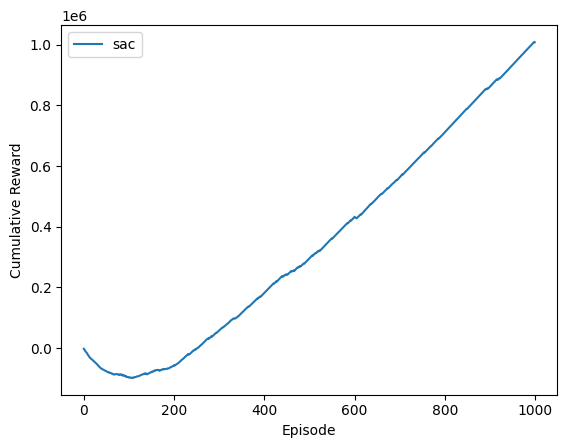

In [13]:
from stable_baselines3 import DDPG,SAC, TD3, A2C, PPO
sac = SAC.load("models/model_sac.zip")
#ppo = PPO.load("models/model_ppo.zip")
#a2c = A2C.load("models/model_a2c.zip")
test = gymnasium.make("CurvyRaceEnv-v0")

rewards = {}
rewards["sac"] = load_log("logs/sac.monitor.csv")
#rewards["test"] = load_log("logs/best_model_log/evaluations.npz")
#rewards["a2c"] = load_log("logs/a2c.monitor.csv")
#rewards["ppo"] = load_log("logs/ppo.monitor.csv")



plot_cumulative_rewards(rewards)

C:\Studium\MasterStudium\DRL\Studienarbeiten\Studienarbeit2\DRL_Studienarbeit2_env\Lib\site-packages\gymnasium\utils\passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(


obs: [ 0.600007   -0.12643929  0.12754057  1.405691   31.430021  ]
obs: [ 1.3195375  -0.03416909  0.35583866  0.6813198  30.71546   ]
obs: [ 2.0553913   0.2393178   0.25288895  0.24564445 29.995079  ]
obs: [2.7548220e+00 4.2006576e-01 2.4423493e-02 1.3141246e+00 2.9308140e+01]
obs: [ 3.3005087   0.43339598 -0.08859523  0.82287306 28.764542  ]
obs: [ 3.9645348   0.37441203 -0.11093491  0.37608796 28.098055  ]
obs: [ 4.5889344   0.30485874 -0.28099585  0.6631612  27.47042   ]
obs: [ 4.791351    0.24643478 -0.4341253   1.4243221  27.26464   ]
obs: [ 5.0731306   0.11579494 -0.7890973   1.2809782  26.975306  ]
obs: [ 5.2212768 -0.0334512 -1.1832241  1.2939981 26.818851 ]
obs: [ 5.285173   -0.18997495 -1.5672616   1.3881708  26.746927  ]
obs: [ 5.285621   -0.31672406 -1.9666903   1.498032   26.740572  ]
obs: [ 5.2277546  -0.45517346 -2.361025    1.6473898  26.792625  ]
obs: [ 5.1556873 -0.5265477 -2.7606337  1.7444804 26.861958 ]
obs: [ 5.0336065  -0.57544416 -3.1527362   1.8482264  26.98223

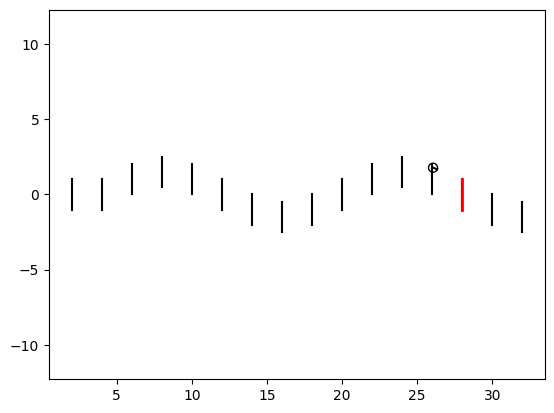

[4.8549682691396825,
 4.9268111790626765,
 13.007380077595117,
 -1.2763351498634403,
 9.030315545685056,
 9.476828609911358,
 26.794368661298442,
 2.2543949937724417,
 11.975086206642638,
 1.1837269978602114,
 0.10326662255354968,
 -1.1069218191951613,
 -2.4837181330145732,
 -3.781896271826051,
 -5.169810525052691,
 -6.380070044605896,
 -7.553122637832153,
 1.3127351939873009,
 0.35170209494952953,
 -0.3230662630083456,
 -0.16973105010910672,
 0.5985361269607186,
 0.41550101008163765,
 39.475578238969504,
 18.32864891241992,
 20.382902173407253,
 52.80286394360068,
 23.55169414532208,
 65.01231402890774,
 13.515144164037661,
 25.481927717917834,
 28.57149062449093,
 78.89987453816758,
 20.605679517167175,
 34.247196697385455,
 91.90332094434386,
 24.840747197621116,
 104.04277395169265,
 24.99145184860314,
 37.053814878999766,
 40.265662683334575,
 117.30770189076975,
 28.58072318113541,
 39.36297611550917,
 43.5716615015576,
 130.03644142959257,
 30.435413535967584,
 41.74764498489199

In [14]:
run_env(test, sac)

In [ ]:
test.action_space

In [ ]:
test.observation_space

In [ ]:
sum(rewards)